In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from datetime import datetime

from os import listdir
from os.path import isdir, join
import pickle as pk
import random
import glob

from tqc.single_state_mdp import SingleStateMDP
from tqc.structures import Trainer, Critic, ReplayBuffer
from tqc.utils import custom_params

sns.set_theme(style="ticks", palette="tab10", rc=custom_params)

## 1. Hopper

### Ours

In [2]:
env = "Hopper-v3"
cdir = f"logs/{env}/"


def smooth(arr, mask_size):
    s = pd.Series(arr)
    return s.rolling(mask_size).mean()


In [3]:
tqc_rewards = []
sac_rewards = []

for d in listdir(cdir):
    path = join(cdir, d)
    if not isdir(path):
        continue

    if "TQC" in d:
        with np.load(path + "/evaluations.npz") as data:
            tqc_rewards.append(data["results"])
            timesteps = data["timesteps"]

    elif "SAC" in d:
        with np.load(path + "/evaluations.npz") as data:
            sac_rewards.append(data["results"])

mask_size = 100

tqc_mean = smooth(np.mean(tqc_rewards, axis=(0, 2)), mask_size=mask_size)
tqc_std = tqc_mean.std()

sac_mean = smooth(np.mean(sac_rewards, axis=(0, 2)), mask_size=mask_size)
sac_std = tqc_mean.std()


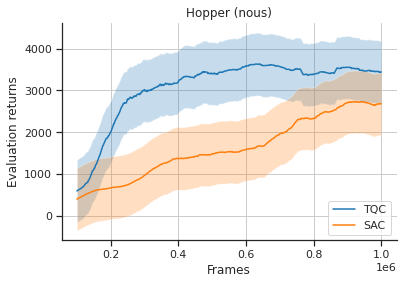

In [4]:
sns.set_theme(style="ticks", palette="tab10", rc=custom_params)

fig, ax = plt.subplots()

ax.plot(timesteps, tqc_mean, label="TQC")
ax.fill_between(timesteps, tqc_mean + tqc_std, tqc_mean - tqc_std, alpha=0.25)

ax.plot(timesteps, sac_mean, label="SAC")
ax.fill_between(timesteps, sac_mean + sac_std, sac_mean - sac_std, alpha=0.25)

ax.set_title(f"{env[:-3]} (nous)")
ax.set_xlabel("Frames")
ax.set_ylabel("Evaluation returns")
ax.legend(loc="lower right")
# ax.set_xlim(xmax=3e6)
# ax.legend(loc='upper right')

fig.show()
fig.savefig(
    f"plots/{env[:-3].lower()}_tqc_sac_smoothed.png",
    facecolor="white",
    transparent=False,
)


### Paper

In [5]:
with open("data/tqc_curves.pkl", "rb") as f:
    tqc_curves = pk.load(f)

t = np.linspace(0, 3e6, 3001)

t_mean = np.mean(tqc_curves["Hopper"]["TQC"], axis=0)
t_smoothed = smooth(t_mean, mask_size=100)
t_std = t_smoothed.std()

s_mean = np.mean(tqc_curves["Hopper"]["SAC"], axis=0)
s_smoothed = smooth(s_mean, mask_size=100)
s_std = s_smoothed.std()


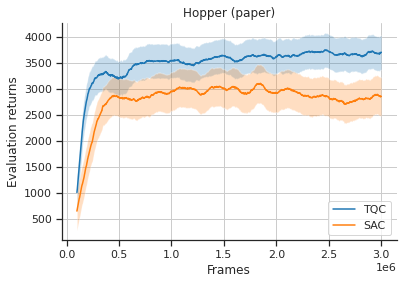

In [6]:
fig, ax = plt.subplots()

ax.plot(t, t_smoothed, label="TQC")
ax.fill_between(t, t_smoothed + t_std, t_smoothed - t_std, alpha=0.25)

ax.plot(t, s_smoothed, label="SAC")
ax.fill_between(t, s_smoothed + s_std, s_smoothed - s_std, alpha=0.25)

ax.set_title(f"{env[:-3]} (paper)")
ax.set_xlabel("Frames")
ax.set_ylabel("Evaluation returns")
ax.legend(loc="lower right")

plt.show()
fig.savefig(
    f"plots/{env[:-3].lower()}_tqc_sac_original.png",
    facecolor="white",
    transparent=False,
)


## 2. Single State MDP

### Reward function

In [2]:
def plot_mdp_reward(n, env, savefig=False):
    actions = np.linspace(-1, 1, n)
    rewards = np.zeros(n)
    targets = np.zeros(n)

    # Build the reward function
    env.reset()
    for i, action in enumerate(actions):
        a = action.item()
        _, reward, _, _ = env.step(a)
        targets[i] = env._mean_reward(a)
        rewards[i] = reward

    # Plot the reward function
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(actions, targets, color="r", linewidth=3, label="$f(a)$")
    ax.scatter(actions, rewards, label="samples from $R(a)$")

    ax.set_ylim(ymin=-2.25)
    ax.legend()

    if savefig:
        fig.savefig("plots/reward_function_cos")

    plt.show()


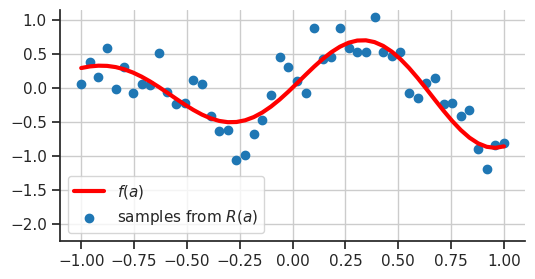

In [3]:
env = SingleStateMDP()
plot_mdp_reward(50, env)


### Robust average

In [4]:
n_seeds = 100
seeds = np.random.randint(0, 2**32 - 1, n_seeds)

n_quantiles_to_drop = [0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 16]
n_networks_avg = [3, 5, 10, 20, 50]
n_networks_min = [2, 3, 4, 6, 8, 10]


#### TQC

In [5]:
n_params = len(n_quantiles_to_drop)

tqc_means = np.zeros((n_params, n_seeds))
tqc_variances = np.zeros((n_params, n_seeds))
tqc_distances = np.zeros((n_params, n_seeds))

for i, d in enumerate(n_quantiles_to_drop):
    for j, seed in enumerate(seeds):
        # Setup env
        env = SingleStateMDP(seed=seed)

        # Setup Q-networks
        critic = Critic(n_nets=2, n_quantiles=25)
        trainer = Trainer(critic, quantiles_to_drop=d, bias_correction_method="TQC")

        # Training the critic
        train_action_grid = torch.linspace(-1, 1, 50)
        train_replay_buffer = ReplayBuffer(env, train_action_grid, max_size=50)

        trainer.train(train_replay_buffer, 3000)

        # Evaluate
        eval_action_grid = torch.linspace(-1, 1, 2000)
        eval_replay_buffer = ReplayBuffer(env, eval_action_grid, max_size=2000)

        mean, var, distance = trainer.evaluate(env, eval_replay_buffer)

        tqc_means[i, j] = mean
        tqc_variances[i, j] = var
        tqc_distances[i, j] = distance


#### AVG

In [6]:
n_params = len(n_networks_avg)

avg_means = np.zeros((n_params, n_seeds))
avg_variances = np.zeros((n_params, n_seeds))
avg_distances = np.zeros((n_params, n_seeds))

for i, N in enumerate(n_networks_avg):
    for j, seed in enumerate(seeds):
        # Setup env
        env = SingleStateMDP(seed=seed)

        # Setup Q-networks
        critic = Critic(n_nets=N)
        trainer = Trainer(critic, bias_correction_method="AVG")

        # Training the critic
        train_action_grid = torch.linspace(-1, 1, 50)
        train_replay_buffer = ReplayBuffer(env, train_action_grid, max_size=50)

        trainer.train(train_replay_buffer, 3000)

        # Evaluate
        eval_action_grid = torch.linspace(-1, 1, 2000)
        eval_replay_buffer = ReplayBuffer(env, eval_action_grid, max_size=2000)

        mean, var, distance = trainer.evaluate(env, eval_replay_buffer)

        avg_means[i, j] = mean
        avg_variances[i, j] = var
        avg_distances[i, j] = distance


#### MIN

In [7]:
n_params = len(n_networks_min)

min_means = np.zeros((n_params, n_seeds))
min_variances = np.zeros((n_params, n_seeds))
min_distances = np.zeros((n_params, n_seeds))

for i, N in enumerate(n_networks_min):
    for j, seed in enumerate(seeds):
        # Setup env
        env = SingleStateMDP(seed=seed)

        # Setup Q-networks
        critic = Critic(n_nets=N)
        trainer = Trainer(critic, bias_correction_method="MIN")

        # Training the critic
        train_action_grid = torch.linspace(-1, 1, 50)
        train_replay_buffer = ReplayBuffer(env, train_action_grid, max_size=50)

        trainer.train(train_replay_buffer, 3000)

        # Evaluate
        eval_action_grid = torch.linspace(-1, 1, 2000)
        eval_replay_buffer = ReplayBuffer(env, eval_action_grid, max_size=2000)

        mean, var, distance = trainer.evaluate(env, eval_replay_buffer)

        min_means[i, j] = mean
        min_variances[i, j] = var
        min_distances[i, j] = distance


#### Figure

In [8]:
date = datetime.now().strftime("%m%d_%H%M%S")
resdir = f"data/robust_averages_{date}.pkl"

robust_averages = {
    "TQC": {"means": tqc_means, "variances": tqc_variances, "distances": tqc_distances},
    "AVG": {"means": avg_means, "variances": avg_variances, "distances": avg_distances},
    "MIN": {"means": min_means, "variances": min_variances, "distances": min_distances},
}

with open(resdir, "wb") as f:
    pk.dump(robust_averages, f, protocol=pk.HIGHEST_PROTOCOL)

In [9]:
filename = f"robust_averages_{date}"
# filename = f"robust_averages_0104_193731"

with open(f"data/{filename}.pkl", "rb") as f:
    datas = pk.load(f)

In [12]:
def get_xyd(data, tail=10):
    x = np.sort(data["means"], axis=1)[:, tail:-tail].mean(axis=1)
    y = np.sort(data["variances"], axis=1)[:, tail:-tail].mean(axis=1)
    d = np.sort(data["distances"], axis=1)[:, tail:-tail].mean(axis=1)

    return x, y, d


def get_sizes(tqc_dist, avg_dist, min_dist, min_norm=100, max_norm=500):
    tqc_size, avg_size, min_size = 1.0 / tqc_dist, 1.0 / avg_dist, 1.0 / min_dist

    all_size = np.concatenate((tqc_size, avg_size, min_size))
    max_s, min_s = all_size.max(), all_size.min()

    tqc_size = normalize(tqc_size, min_s, max_s, min_norm, max_norm)
    avg_size = normalize(avg_size, min_s, max_s, min_norm, max_norm)
    min_size = normalize(min_size, min_s, max_s, min_norm, max_norm)

    return tqc_size, avg_size, min_size


def normalize(sizes, min_size, max_size, min_norm, max_norm):
    norm_sizes = (sizes - min_size) / (max_size - min_size)
    return norm_sizes * (max_norm - min_norm) + min_norm

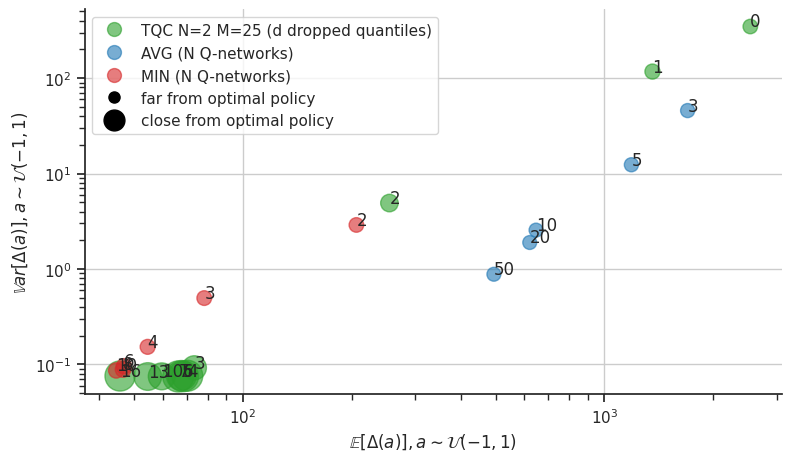

In [14]:
sns.set_theme(style="ticks", palette="tab10", rc=custom_params)

fig, ax = plt.subplots(figsize=(8, 5))

tqc_x, tqc_y, tqc_d = get_xyd(datas["TQC"])
avg_x, avg_y, avg_d = get_xyd(datas["AVG"])
min_x, min_y, min_d = get_xyd(datas["MIN"])

tqc_s, avg_s, min_s = get_sizes(tqc_d, avg_d, min_d)

# TQC
ax.scatter(
    tqc_x, tqc_y, s=tqc_s, color="#2ca02c", alpha=0.6, label="TQC N=2 M=25 (d dropped quantiles)"
)

for i in range(len(n_quantiles_to_drop)):
    ax.annotate(str(n_quantiles_to_drop[i]), (tqc_x[i], tqc_y[i]))

# AVG
ax.scatter(avg_x, avg_y, s=avg_s, color="#1f77b4", alpha=0.6, label="AVG (N Q-networks)")

for i in range(len(n_networks_avg)):
    ax.annotate(str(n_networks_avg[i]), (avg_x[i], avg_y[i]))

# MIN
ax.scatter(min_x, min_y, s=min_s, color="#d62728", alpha=0.6, label="MIN (N Q-networks)")

for i in range(len(n_networks_min)):
    ax.annotate(str(n_networks_min[i]), (min_x[i], min_y[i]))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$\mathbb{E}[\Delta(a)], a \sim \mathcal{U}(-1,1)$")
ax.set_ylabel("$\mathbb{V}ar[\Delta(a)], a \sim \mathcal{U}(-1,1)$")
ax.legend(loc="upper left")

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='#2ca02c', alpha=0.6, markerfacecolor='#2ca02c', 
           markersize=10, label='TQC N=2 M=25 (d dropped quantiles)', linestyle='none'),
    Line2D([0], [0], marker='o', color='#1f77b4', alpha=0.6, markerfacecolor='#1f77b4', 
           markersize=10, label='AVG (N Q-networks)', linestyle='none'),
    Line2D([0], [0], marker='o', color='#d62728', alpha=0.6, markerfacecolor='#d62728', 
           markersize=10, label='MIN (N Q-networks)', linestyle='none'),
    Line2D([0], [0], marker='o', color='black', markersize=8,
           label='far from optimal policy', linestyle='none'),
    Line2D([0], [0], marker='o', color='black', markersize=15,
           label='close from optimal policy', linestyle='none'),
]
ax.legend(loc="upper left", handles=legend_elements)

fig.savefig(
    f"plots/toy_robust_average_100_seeds.png", facecolor="white", transparent=False
)
plt.show()
